# A deblurring task - Andrea Virgillito

### Imports

In [2]:
import random
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Reshape, Conv2DTranspose, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

### Dataset creation

In [1]:
from cv2 import GaussianBlur

def getDataset():
  (x_train, _), (x_test, _) = tf.ks.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

#### Getting the dataset and splitting it into training set and test set.<br>
#### If the dataset has already been created then we just load it.

In [2]:
try:
    with open('dataset.pickle', 'rb') as file:
        (x_train, y_train), (x_test, y_test) = pickle.load(file)

except:
    dataset = getDataset()
    (x_train, y_train), (x_test, y_test) = dataset
    with open('dataset.pickle', 'wb') as file:
        pickle.dump(dataset, file)

#### Defining some auxiliary functions

In [4]:
def display_history(history):

    mse_training = history.history['loss']
    mse_val = history.history['val_loss']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    acc_training = history.history['accuracy']
    acc_val = history.history['val_accuracy']

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

def show_images(model):

  random_num=random.randint(0,9995)
  
  # ORIGINAL and BLURRED IMAGES
  print()
  print("ORIGINAL and BLURRED IMAGES")
  print()
  for set in [y_test,x_test]:

    f, axarr = plt.subplots(1, 5)
    f.set_size_inches(16, 6)

    for i in range(5):
        imgg = set[i+random_num]
        axarr[i].imshow(imgg)
    plt.show()

  # RECONSTRUCTED IMAGES
  print()
  print("RECONSTRUCTED IMAGES")
  print()
  f, axarr = plt.subplots(1, 5)
  f.set_size_inches(16, 6)

  for i in range(5):
      imgg = model.predict(np.expand_dims(x_test[i+random_num], axis=0))[0]
      axarr[i].imshow(imgg)
  plt.show()

# Pure Convolutional Network

#### Having explored many possibilities, the following is the convolutional neural network I am going to submit for this exam. <br>
#### This project has been partially inspired by the following two papers https://arxiv.org/abs/2201.10700,  https://arxiv.org/abs/1907.10128.

#### One of the main points we need to keep in mind is that in order to accomplish this task we should not just elaborate information from the input but somehow we also have to **generate** new data. So, to be able to achieve a result, we would expect a sudden increasing in the size of feature maps somewhere in the network. <br> It is worth to say a few words about its construction. <br>
- #### In the first layer we have produced 128 filters, this size has been empirically proven to suggest to the network an acceptable amount of hypotheses about all the possible way to reconstruct the image. <br>

- #### Since the Gaussian blurring filter has size (5,5), considering a patch centerd in a given pixel in the blurred image the information we desire to associate to it are contained within a window the size of which is bigger or equal to that of a 5x5 kernel. The better choice has been proven to be a 7x7 kernel, thus advising that for each pixel our network also needs some context beside the area of the Gaussian blurring. <br> In this way we are exploiting the fact that this is a non-blind denoising.

- #### The part of the network that can be recognized as an "encoder" is completed with a third convolutional layer and the job of regaining the size of a 32x32 image with 3 color channels is done by means of transposed convolutions; this mainly because every attempt of introducing MaxPooling2D layers has shown a worsening in the performance.

#### <br> After many trials the following is the final version of the network:

In [20]:
img = Input(shape=(32,32,3))
x = Conv2D(128,(7,7),strides=1, padding='same', activation='relu')(img)
x = Conv2D(256,(5,5),strides=2, padding='same', activation='relu')(x)
x = Conv2D(128,(3,3),strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(128, 3, 2, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, 3, 2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, 1, padding='same', activation='relu')(x)
x = Conv2DTranspose(16, 3, 1, padding='same', activation='relu')(x)
x = Conv2DTranspose(3, 3, 1, padding='same', activation='sigmoid')(x)

model = Model(img, x)
model.summary()
model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-3, beta_1=0.95),
                  loss='mse',
                  metrics='accuracy')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       18944     
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 256)       819456    
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 32, 32, 64)       73792     
 ranspose)                                                 

#### In the very first trials the following EarlyStopping based on the training loss has saved us a lot of time and energy.

In [ ]:
from tensorflow.ks.callbacks import EarlyStopping

callback = EarlyStopping(monitor="loss",
                         mode = "min",
                         min_delta=0.000004,
                         patience=4,
                         verbose = 2)

#### The validation set is not needed because all the networks I tried for this task never suffered of overfitting: this fact can be related to the type of task.

In [ ]:
BATCH_SIZE = 32
N_EPOCHS = 60

model_hist = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_test, y_test), callbacks=[callback,tensorboard_callback])

Epoch 1/60
1563/1563 [==============================] - 32s 20ms/step - loss: 0.0071 - accuracy: 0.7144 - val_loss: 0.0040 - val_accuracy: 0.8202
Epoch 2/60
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0038 - accuracy: 0.8217 - val_loss: 0.0036 - val_accuracy: 0.8110
Epoch 3/60
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0033 - accuracy: 0.8293 - val_loss: 0.0031 - val_accuracy: 0.8322
Epoch 4/60
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0031 - accuracy: 0.8329 - val_loss: 0.0030 - val_accuracy: 0.8417
Epoch 5/60
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0030 - accuracy: 0.8364 - val_loss: 0.0029 - val_accuracy: 0.8436
Epoch 6/60
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0029 - accuracy: 0.8378 - val_loss: 0.0029 - val_accuracy: 0.8307
Epoch 7/60
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0028 - accuracy: 0.8390 - val_loss: 0.0028 -

In [ ]:
# # model.save_weights('deblur_0.0022.h5')

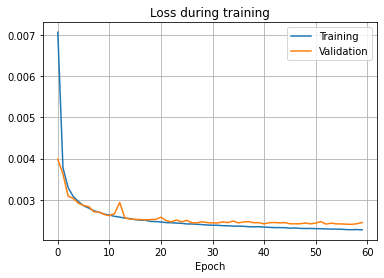

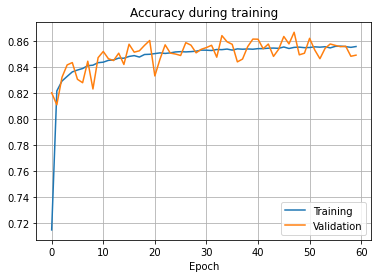

In [ ]:
display_history(model_hist)

#### With few more epoches we can reach a mse of 0.0022 in the training set and 0.0023 in the test_set.

In [ ]:
BATCH_SIZE = 64
N_EPOCHS = 40

model_hist = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_test, y_test), callbacks=[callback,tensorboard_callback])

Epoch 1/40
782/782 [==============================] - 25s 32ms/step - loss: 0.0022 - accuracy: 0.8613 - val_loss: 0.0024 - val_accuracy: 0.8643
Epoch 2/40
782/782 [==============================] - 25s 32ms/step - loss: 0.0022 - accuracy: 0.8614 - val_loss: 0.0023 - val_accuracy: 0.8747
Epoch 3/40
782/782 [==============================] - 26s 33ms/step - loss: 0.0022 - accuracy: 0.8515 - val_loss: 0.0023 - val_accuracy: 0.8545
Epoch 4/40
782/782 [==============================] - 25s 32ms/step - loss: 0.0022 - accuracy: 0.8514 - val_loss: 0.0023 - val_accuracy: 0.8652
Epoch 5/40
782/782 [==============================] - 26s 33ms/step - loss: 0.0022 - accuracy: 0.8514 - val_loss: 0.0023 - val_accuracy: 0.8646
Epoch 6/40
782/782 [==============================] - 26s 33ms/step - loss: 0.0022 - accuracy: 0.8516 - val_loss: 0.0023 - val_accuracy: 0.8476
Epoch 6: early stopping


## Visualizing the result of the pure convolutional network.


ORIGINAL and BLURRED IMAGES



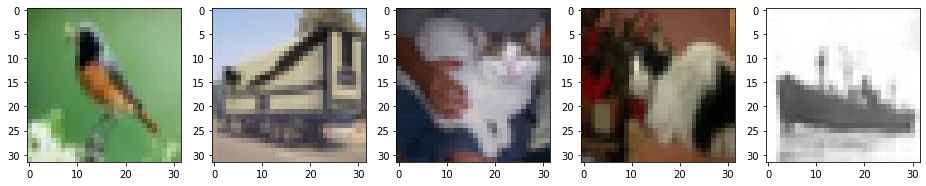

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


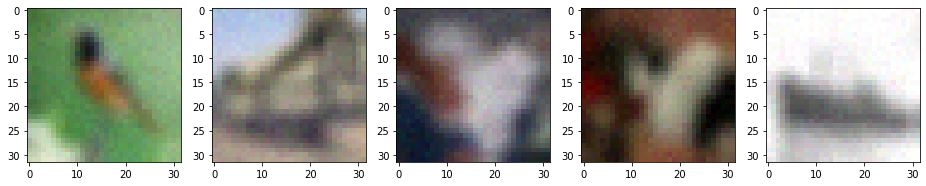


RECONSTRUCTED IMAGES



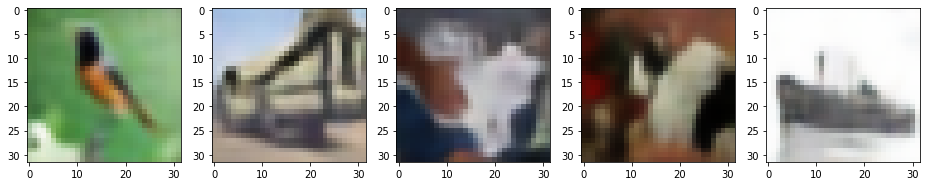

In [ ]:
show_images(model)

In [53]:
random_num=random.randint(0,10000)
m = tf.ks.metrics.MeanSquaredError()
m.update_state(y_test[random_num:random_num+500], model(x_test[random_num:random_num+500]))
print(m.result().numpy())

0.0024909198


# Convolutional Residual Network

#### A more sofisticated attempt has been made with a slightly modification of the previous network and the addition of a residual layer. <br>

#### - Now a residual connection directly adds the input to the output of the previous network, this because we can supposed that all in all the blurred image is a good starting point for the reconstruction: the rest of the network should only learn how to balance the Gaussian noise introduced.

#### - Note that the last activation function is a **tanh** scaled by 2/3, so we are actually computing the corrections to the noise (a different scaling factor is not so good).

In [54]:
img = Input(shape=(32,32,3))
x = Conv2D(128,(5,5),strides=1, padding='same', activation='relu')(img)
x = Conv2D(256,(3,3),strides=2, padding='same', activation='relu')(x)
x = Conv2D(128,(3,3),strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, 3, 2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, 2, padding='same', activation='relu')(x)
x = Conv2DTranspose(3, 3, 1, padding='same', activation='tanh')(x)
x = tf.ks.layers.Rescaling(2/3)(x)
residual_layer = Add()([img,x])

residual = Model(img, residual_layer)
residual.summary()
residual.compile(optimizer=ks.optimizers.Adam(learning_rate=3*1e-4, beta_1=0.95),
                  loss='mse',
                  metrics='accuracy')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 128)  9728        ['input_5[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 256)  295168      ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 8, 8, 128)    295040      ['conv2d_9[0][0]']               
                                                                                            

In [ ]:
from tensorflow.ks.callbacks import EarlyStopping

callback = EarlyStopping(monitor="loss",
                         mode = "min",
                         min_delta=0.000004,
                         patience=3,
                         verbose = 2)

BATCH_SIZE = 32
N_EPOCHS = 70

residual_hist = residual.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_test, y_test), callbacks=[callback,tensorboard_callback])

Epoch 1/70
1563/1563 [==============================] - 29s 12ms/step - loss: 0.0040 - accuracy: 0.7799 - val_loss: 0.0034 - val_accuracy: 0.7826
Epoch 2/70
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0033 - accuracy: 0.7820 - val_loss: 0.0032 - val_accuracy: 0.7833
Epoch 3/70
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0032 - accuracy: 0.7825 - val_loss: 0.0031 - val_accuracy: 0.7832
Epoch 4/70
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0031 - accuracy: 0.7828 - val_loss: 0.0031 - val_accuracy: 0.7838
Epoch 5/70
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0030 - accuracy: 0.7830 - val_loss: 0.0030 - val_accuracy: 0.7835
Epoch 6/70
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0030 - accuracy: 0.7831 - val_loss: 0.0030 - val_accuracy: 0.7844
Epoch 7/70
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0030 - accuracy: 0.7833 - val_loss: 0.0030 -

In [ ]:
# # residual.save_weights('deblur_residual.h5')

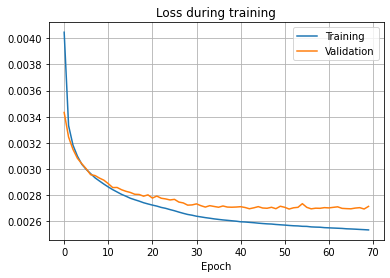

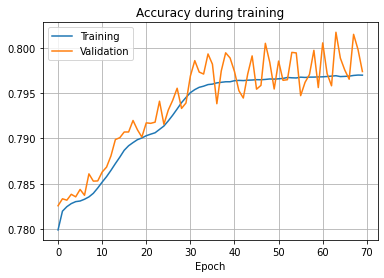

In [ ]:
display_history(residual_hist)

## Visualizing the result of the residual convolutional network.


ORIGINAL and BLURRED IMAGES



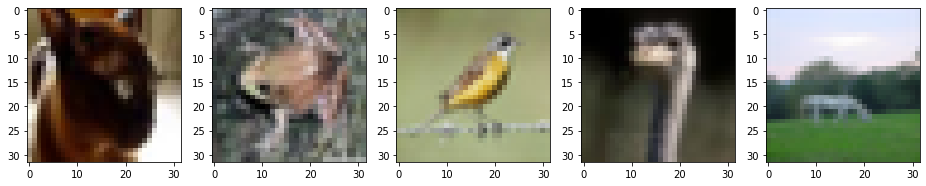

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


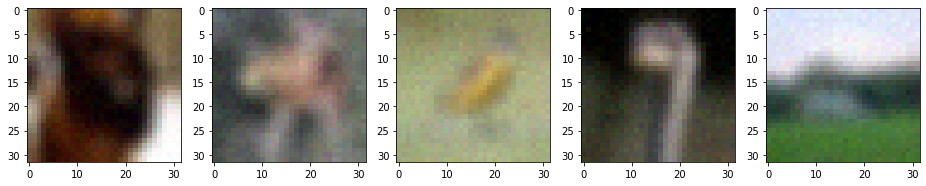

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



RECONSTRUCTED IMAGES



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


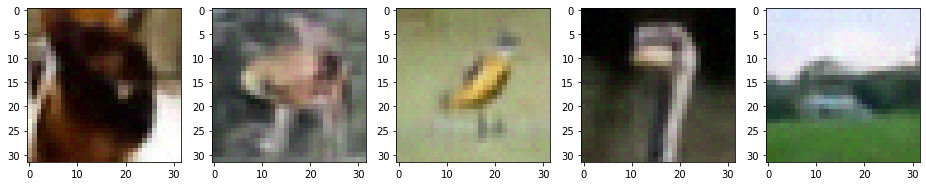

In [ ]:
show_images(residual)

In [58]:
random_num=random.randint(0,10000)
m = tf.ks.metrics.MeanSquaredError()
m.update_state(y_test[random_num:random_num+500], residual(x_test[random_num:random_num+500]))
print(m.result().numpy())

0.0026893083


### Those results are clearly not so good as the previous but we observe that the number of parameter is **halved**.

# Variational AutoEncoder

#### Yet another feasible path was that of implementing a Variational Autoencoder. <br> VAEs are autoencoders that produce a probabilistic latent space, thus providing the decoder with a latent space composed of probable values this will, in principle, tend to improve the consistency of the reconstructed image. <br> The idea is just we would like to exploit the fact that we are aiming to a non-blind denoising. <br> However those experiments have not led to satisfactory results.

# [SUnet](https://arxiv.org/pdf/2202.14009.pdf) made from the comparison with another student work, here just to illustrate how this task can be accomplished with a deeper methodology.

#### SUnet is a Unet-shaped architecture which makes use of Swin Transformers, in order to mimic the usage of different content-dependent convolutional kernels and to capture global information that cannot be (completely) acquired by deep-convolutions, since features are based on small patches.

#### The network works as follows:
1. the image is projected into an "embedding space". A convolutional layer with kernel size and strides equal to a provided patch size generates C features where each pixel is a distinct representation of a patch_size x patch_size patch. In this way, pixels are independent each other, since they belongs to different patches.
2. feature maps are passed to the U-shaped model
3. a 3x3 convolutional layer projects back the features in the "image space"

Step 2 is where Swin Transformers are used. The differences with the classical UNet are:
- convolutions are replaced by swin transformers
- downsampling is made through Patch merging: input features of each group of 2x2 neighboring patches are concatenated and then projected via a dense layer into a H/2*W/2 x 4*C
- dual up-sampling, introduced in the paper, is used instead of transponse convolution: it concatenates features obtained through bilinear upsampling and pixel shuffle
<br>
Since multi-head (self) attention (MSA) needs a sequence as input, along the whole network images are continuosly reshaped from $H x W x C$ to $H*W x C$ and viceversa

## Swin Transformer
[Swin Transformer](https://arxiv.org/pdf/2103.14030.pdf) is an adaptation of the classical transformer to vision tasks. They solve two main problems:
1. Reduce the number of parameters needed for a sequence
2. Allow pixel-wise level task

They are very similar to classical transformers used in NLP, except for the fact that they make use of a 2D window-mask. A 2D attention mask (what is outside the window will be ignored) is shifted along subsequent transformers in order to "group" together different patches. Patches are then flattened along H,W axes and used in the MSA

Shifting the window allows to have different sequences with different local contexts. The window is shifted in a cyclic manner, so that to always have patches of window size. As we can see from the figure below, the images is closed in a cube, so that top and bottom are neighbors, such as left and right

Swin transformers should always be used in block of multiples of 2, where the first one uses W-MSA (window-MSA, without shifting), and the second one uses SW-MSA (shifted-window-MSA, the window of the previous layer is shifted to top-left)

The code below has been adapted to my needs:
- Swin Transformers are taken from [here](https://ks.io/examples/vision/swin_transformers/) and adapted to SUnet
- SUnet code is a (partial) porting I made from Pytorch to ks which comes from the authors of the paper's repository [here](https://github.com/FanChiMao/SUNet).

In particular I used a new layer known as UpsampleOut (based on Upsample) as output layer, since the original code do not allow to use a patch size different than 4. With this layer, patch size can be a multiple of 2.

### Params
- features: starting number of channels. It must be a multiple of num_heads (the number of heads in the MSA)
- patch_size: small enough
- window_size: H, W must be multiples of window_size
- depths: number of swin transformers at each layer (must be multiples of 2)
- num_heads: number of heads of the MSA

Since there are a lot of constraints and the images are very small, there is not so much tuning that can be done. The parameters below are the only one that fits with all the given constraints.
If I had not the limit on the number of learnable parameters, I could have tried different values of features, such as 72 or 96.

In [ ]:
features = 48 # num_heads should be divisible by this parameter
patch_size = 2
window_size = 4 # height and width must be multiples of window_size

depths=[2, 2, 2, 2]
num_heads=[3, 6, 12, 24]
num_layers = len(depths)


input_shape = x_train.shape[1:]
img_size = input_shape[0]
img_channels = input_shape[-1]

In [ ]:
# Source: https://ks.io/examples/vision/swin_transformers/
class SwinTransformer(ks.layers.Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4., qkv_bias=True, dropout_rate=0.0):
        super().__init__()
        
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.dropout_rate = dropout_rate
        

        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must be in [0, window_size)"
        
        self.norm1 = ks.layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim, window_size=(self.window_size, self.window_size),
            num_heads=num_heads, qkv_bias=qkv_bias
        )
        
        self.norm2 = ks.layers.LayerNormalization(epsilon=1e-5)
        num_mlp = int(dim * mlp_ratio)
        self.mlp = ks.Sequential(
            [
                ks.layers.Dense(num_mlp),
                ks.layers.Activation(ks.activations.gelu),
                ks.layers.Dropout(dropout_rate),
                ks.layers.Dense(dim),
                ks.layers.Dropout(dropout_rate),
            ]
        )

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.input_resolution
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(mask_windows, shape=[-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.input_resolution
        _, num_patches_before, channels = x.shape
        
        assert num_patches_before == height * width, f"input feature has wrong size: {num_patches_before} != {height} * {width}"
        
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        
        # cyclic shift: top, left
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x
        
        # partition windows (get a list of patches)
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(x_windows, shape=(-1, self.window_size * self.window_size, channels)) # img to token
        
        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # merge windows (merge patches to get back the whole image)
        attn_windows = tf.reshape(attn_windows, shape=(-1, self.window_size, self.window_size, channels)) # token to img
        shifted_x = window_reverse(attn_windows, self.window_size, height, width, channels)
        
        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))  # img to token
        
        x = x_skip + x
        
        x_skip = x        
        x = self.norm2(x)
        x = self.mlp(x)
        
        x = x_skip + x
        
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'num_heads': self.num_heads,
            'window_size': self.window_size,
            'shift_size': self.shift_size,
            'mlp_ratio': self.mlp_ratio,
            'qkv_bias': self.qkv_bias,
            'dropout_rate': self.dropout_rate,
        })
        return config

class WindowAttention(ks.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs):
        super(WindowAttention, self).__init__(**kwargs)
        
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.qkv_bias = qkv_bias
        self.dropout_rate = dropout_rate
        
        self.scale = (dim // num_heads) ** -0.5
        
        self.qkv = ks.layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = ks.layers.Dropout(dropout_rate)
        self.proj = ks.layers.Dense(dim)

    def build(self, input_shape):
        # (2M −1)×(2M −1) Bias table (learnable)
        num_window_elements = (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1)
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
            name='relative_position_bias_table'
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1) # relative positions from top_right corner   

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        
        # qkv projection
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        
        # --- masked scaled dot-product + Bias ---
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k
        
        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(self.relative_position_index, shape=(-1,))
        relative_position_bias = tf.gather(self.relative_position_bias_table, relative_position_index_flat)
        relative_position_bias = tf.reshape(relative_position_bias, shape=(num_window_elements, num_window_elements, -1))
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0) # add bias to scaled-dot product
        
        
        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), ks.backend.floatx()) # 1 x nW x 1 x ...
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size)) # None x nW x num_heads x size x size 
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size)) # batch_size x num_heads x size x size 
            attn = ks.activations.softmax(attn, axis=-1)
        else:
            attn = ks.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        # attention(Q,K,V) = softmax( QK^T/sqrt(dk) + B) V
        x_qkv = attn @ v                                        # batch_size x num_heads x size x head_dim (dk)
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))          # batch_size x size x num_heads x dk
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))   # batch_size x size x channels (=num_heads * dk)
        x_qkv = self.proj(x_qkv)                                # batch_size x size x dim (dim and channels should be equal)
        x_qkv = self.dropout(x_qkv)
        return x_qkv
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'window_size': self.window_size,
            'num_heads': self.num_heads,
            'qkv_bias': self.qkv_bias,
            'dropout_rate': self.dropout_rate,
        })
        return config

# Helpers
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    n_patch_y = height // window_size
    n_patch_x = width // window_size
    
    x = tf.reshape(x, shape=(-1, n_patch_y, window_size, n_patch_x, window_size, channels))
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows

def window_reverse(windows, window_size, height, width, channels):
    assert height % window_size == 0 and width % window_size == 0, f"{height} and {width} must be multiples of {window_size}"
    n_patch_y = height // window_size
    n_patch_x = width // window_size
    x = tf.reshape(windows, shape=(-1, n_patch_y, n_patch_x, window_size, window_size, channels))
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x

class DropPath(ks.layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [ ]:
class PatchEmbed(ks.layers.Layer):
    def __init__(self, img_size=32, patch_size=4, embed_dim=96, **kwargs):
        super(PatchEmbed, self).__init__(**kwargs)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        self.proj = ks.layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size)
        
        res = img_size // patch_size
        self.patches_resolution = (res, res)
        self.num_patches = res * res
        
    def call(self, x):
        b, h, w, c = x.shape
        
        x = self.proj(x)
        ph, pw = x.shape[1:-1]
        x = tf.reshape(x, shape=(-1, ph*pw, c))
        
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'img_size': self.img_size,
            'patch_size':self.patch_size,
            'embed_dim': self.embed_dim,
        })
        return config
        
class BasicLayer(ks.layers.Layer):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4, qkv_bias=True, downsample=True, **kwargs):
        super(BasicLayer, self).__init__(**kwargs)
        
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.downsample = downsample
        
        self.blocks = [SwinTransformer(dim=dim, input_resolution=input_resolution,
                                            num_heads=num_heads, window_size=window_size,
                                            shift_size=0 if (i % 2 == 0) else window_size // 2,
                                            mlp_ratio=mlp_ratio, qkv_bias=qkv_bias)
                       for i in range(depth)]
        
        if downsample:
            self.downsample_l = PatchMerging(input_resolution, dim=dim)
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        
        if self.downsample:
            x = self.downsample_l(x)
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'depth': self.depth,
            'num_heads': self.num_heads,
            'window_size': self.window_size,
            'mlp_ratio': self.mlp_ratio,
            'qkv_bias': self.qkv_bias,
            'downsample': self.downsample,
        })
        return config
    
class BasicLayerUp(ks.layers.Layer):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4, qkv_bias=True, upsample=True, **kwargs):
        super(BasicLayerUp, self).__init__(**kwargs)
        
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.upsample = upsample
        
        self.blocks = [SwinTransformer(dim=dim, input_resolution=input_resolution,
                                            num_heads=num_heads, window_size=window_size,
                                            shift_size=0 if (i % 2 == 0) else window_size // 2,
                                            mlp_ratio=mlp_ratio, qkv_bias=qkv_bias)
                       for i in range(depth)]
        
        if upsample:
            self.upsample_l = UpSample(input_resolution, in_channels=dim, scale_factor=2)
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        
        if self.upsample:
            x = self.upsample_l(x)
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'depth': self.depth,
            'num_heads': self.num_heads,
            'window_size': self.window_size,
            'mlp_ratio': self.mlp_ratio,
            'qkv_bias': self.qkv_bias,
            'upsample': self.upsample,
        })
        return config

class PatchMerging(ks.layers.Layer):
    def __init__(self, input_resolution, dim, **kwargs):
        super(PatchMerging, self).__init__(**kwargs)
        
        self.input_resolution = input_resolution
        self.dim = dim
        
        self.norm = ks.layers.LayerNormalization(epsilon=1e-5)
        self.reduction = ks.layers.Dense(2 * dim, use_bias=False)
        
    def call(self, x):
        h, w = self.input_resolution
        b, l, c = x.shape
        
        assert l == h * w,
        assert h % 2 == 0 and w % 2 == 0, f"x size ({h}*{w}) are not even." 
        
        x = tf.reshape(x, shape=(-1, h, w, c))
        
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat([x0, x1, x2, x3], -1)
        
        x = tf.reshape(x, shape=(-1, h*w//4, 4 * c))
        
        x = self.norm(x)
        x = self.reduction(x)
        
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'dim': self.dim,
        })
        return config
    
class PixelShuffle(ks.layers.Layer):
    def __init__(self, upscale_factor, **kwargs):
        super(PixelShuffle, self).__init__(**kwargs)
        self.upscale_factor = upscale_factor
    
    def call(self, x):
        return tf.nn.depth_to_space(x, self.upscale_factor)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'upscale_factor': self.upscale_factor,
        })
        return config

class UpSample(ks.layers.Layer):
    def __init__(self, input_resolution, in_channels, scale_factor, **kwargs):
        super(UpSample, self).__init__(**kwargs)
        
        self.input_resolution = input_resolution
        self.in_channels = in_channels
        self.scale_factor = scale_factor
        
        if self.scale_factor == 2:
            self.conv = ks.layers.Conv2D(in_channels//2, kernel_size=(1,1), use_bias=False)
            self.up_p = ks.Sequential([ks.layers.Conv2D(2*in_channels, kernel_size=(1,1), use_bias=False),
                                       ks.layers.PReLU(),
                                       PixelShuffle(scale_factor),
                                       ks.layers.Conv2D(in_channels//2, kernel_size=(1,1), use_bias=False)])

            self.up_b = ks.Sequential([ks.layers.Conv2D(in_channels, kernel_size=(1,1)),
                                       ks.layers.PReLU(),
                                       ks.layers.UpSampling2D(size=scale_factor, interpolation='bilinear'),
                                       ks.layers.Conv2D(in_channels // 2, kernel_size=(1,1), use_bias=False)])
        elif self.scale_factor == 4:            
            self.conv = ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)
            self.up_p = ks.Sequential([ks.layers.Conv2D(16*in_channels, kernel_size=(1,1), use_bias=False),
                                       ks.layers.PReLU(),
                                       PixelShuffle(scale_factor),
                                       ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)])

            self.up_b = ks.Sequential([ks.layers.Conv2D(in_channels, kernel_size=(1,1)),
                                       ks.layers.PReLU(),
                                       ks.layers.UpSampling2D(size=scale_factor, interpolation='bilinear'),
                                       ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)])
        
    def call(self, x):
        if type(self.input_resolution) == int:
            h = self.input_resolution
            w = self.input_resolution

        elif type(self.input_resolution) == tuple:
            h, w = self.input_resolution
            
        b, l, c = x.shape
        
        x = tf.reshape(x, shape=(-1, h, w, c))
        x_p = self.up_p(x) # pixel shuffle
        x_b = self.up_b(x) # bilinear
        
        x = ks.layers.concatenate([x_p, x_b])
        x = self.conv(x)
        
        if self.scale_factor == 2:
            c = c//2            
            x = tf.reshape(x, shape=(-1, h*w*4, c))        
        
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'in_channels': self.in_channels,
            'scale_factor': self.scale_factor,
        })
        return config
    
class UpSampleOut(ks.layers.Layer):
    def __init__(self, input_resolution, in_channels, scale_factor, **kwargs):
        super(UpSampleOut, self).__init__(**kwargs)
        
        self.input_resolution = input_resolution
        self.in_channels = in_channels
        self.scale_factor = scale_factor
        
        self.conv = ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)
        self.up_p = ks.Sequential([ks.layers.Conv2D((scale_factor**2)*in_channels, kernel_size=(1,1), use_bias=False),
                                   ks.layers.PReLU(),
                                   PixelShuffle(scale_factor),
                                   ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)])

        self.up_b = ks.Sequential([ks.layers.Conv2D(in_channels, kernel_size=(1,1)),
                                   ks.layers.PReLU(),
                                   ks.layers.UpSampling2D(size=scale_factor, interpolation='bilinear'),
                                   ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)])
        
    def call(self, x):
        if type(self.input_resolution) == int:
            h = self.input_resolution
            w = self.input_resolution

        elif type(self.input_resolution) == tuple:
            h, w = self.input_resolution
            
        b, l, c = x.shape
        
        x = tf.reshape(x, shape=(-1, h, w, c))
        x_p = self.up_p(x) # pixel shuffle
        x_b = self.up_b(x) # bilinear
        
        x = ks.layers.concatenate([x_p, x_b])
        x = self.conv(x)      
        
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'in_channels': self.in_channels,
            'scale_factor': self.scale_factor,
        })
        return config
    
def forward_features(x):    
    patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, embed_dim=features)
    down_layers = []
    for i in range(num_layers):
        layer = BasicLayer(dim=features * 2 ** i,
                           input_resolution = (patch_embed.patches_resolution[0] // (2 ** i),
                                               patch_embed.patches_resolution[1] // (2 ** i)),
                           depth = depths[i],
                           num_heads = num_heads[i],
                           window_size = window_size,
                           downsample=i<num_layers-1)
        down_layers.append(layer)
    norm = ks.layers.LayerNormalization(epsilon=1e-5)
    
    
    residual = x
    x = patch_embed(x)
    x_downsample = []
    for layer in down_layers:
        x_downsample.append(x)
        x = layer(x)

    x = norm(x)
    
    return x, residual, x_downsample, patch_embed.patches_resolution

def forward_up_features(x, x_downsample, patches_resolution):
    up_layers = [
        UpSample(input_resolution=patches_resolution[0] // (2 ** (num_layers - 1)),
                 in_channels=int(features * 2 ** (num_layers - 1)), scale_factor=2)
    ]
    project_back = []
    for i in range(1, num_layers):        
        layer = BasicLayerUp(dim=int(features * 2 ** (num_layers - 1 - i)),
                           input_resolution = (patches_resolution[0] // (2 ** (num_layers - 1 - i)),
                                               patches_resolution[1] // (2 ** (num_layers - 1 - i))),
                           depth = depths[num_layers - 1 - i],
                           num_heads = num_heads[num_layers - 1 - i],
                           window_size = window_size,
                           upsample=i<num_layers-1)
        up_layers.append(layer)        
        project_back.append(ks.layers.Dense(int(features * 2 ** (num_layers - 1 - i))))
    
    norm_up = ks.layers.LayerNormalization(epsilon=1e-5)
    
    layer = up_layers.pop(0)
    x = layer(x)
    for i, layer in enumerate(up_layers):
        x = tf.concat([x, x_downsample[2 - i]], -1)  # concat last dimension
        x = project_back[i](x)
        x = layer(x)

    x = norm_up(x)  # B L C
    
    return x

def up_to_img_size(x, patches_resolution):
    h, w = patches_resolution
    b, l, c = x.shape
    assert l == h * w, "input features has wrong size"
    
    up = UpSampleOut(input_resolution=(img_size // patch_size, img_size // patch_size), in_channels=features, scale_factor=patch_size)
    x = up(x)

    return x


def create_sunet():
    input = ks.layers.Input(shape=input_shape)
    
    # f_shallow
    x = ks.layers.Conv2D(features, kernel_size=(3,3), padding='same')(input)

    
    # f_deep
    x, residual, x_downsample, patches_resolution = forward_features(x)
    x = forward_up_features(x, x_downsample, patches_resolution)
    x = up_to_img_size(x, patches_resolution)

    
    # out
    out = ks.layers.Conv2D(img_channels, kernel_size=(3,3), padding='same')(x)
    
    return ks.Model(input, out)

In [ ]:
model = create_sunet()

model.summary()

7330695
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 32, 32, 48)   1344        ['input_3[0][0]']                
                                                                                                  
 patch_embed_1 (PatchEmbed)     (None, 256, 48)      9264        ['conv2d_42[0][0]']              
                                                                                                  
 basic_layer_4 (BasicLayer)     (None, 64, 96)       80262       ['patch_embed_1[0][0]']          
                                                                                    

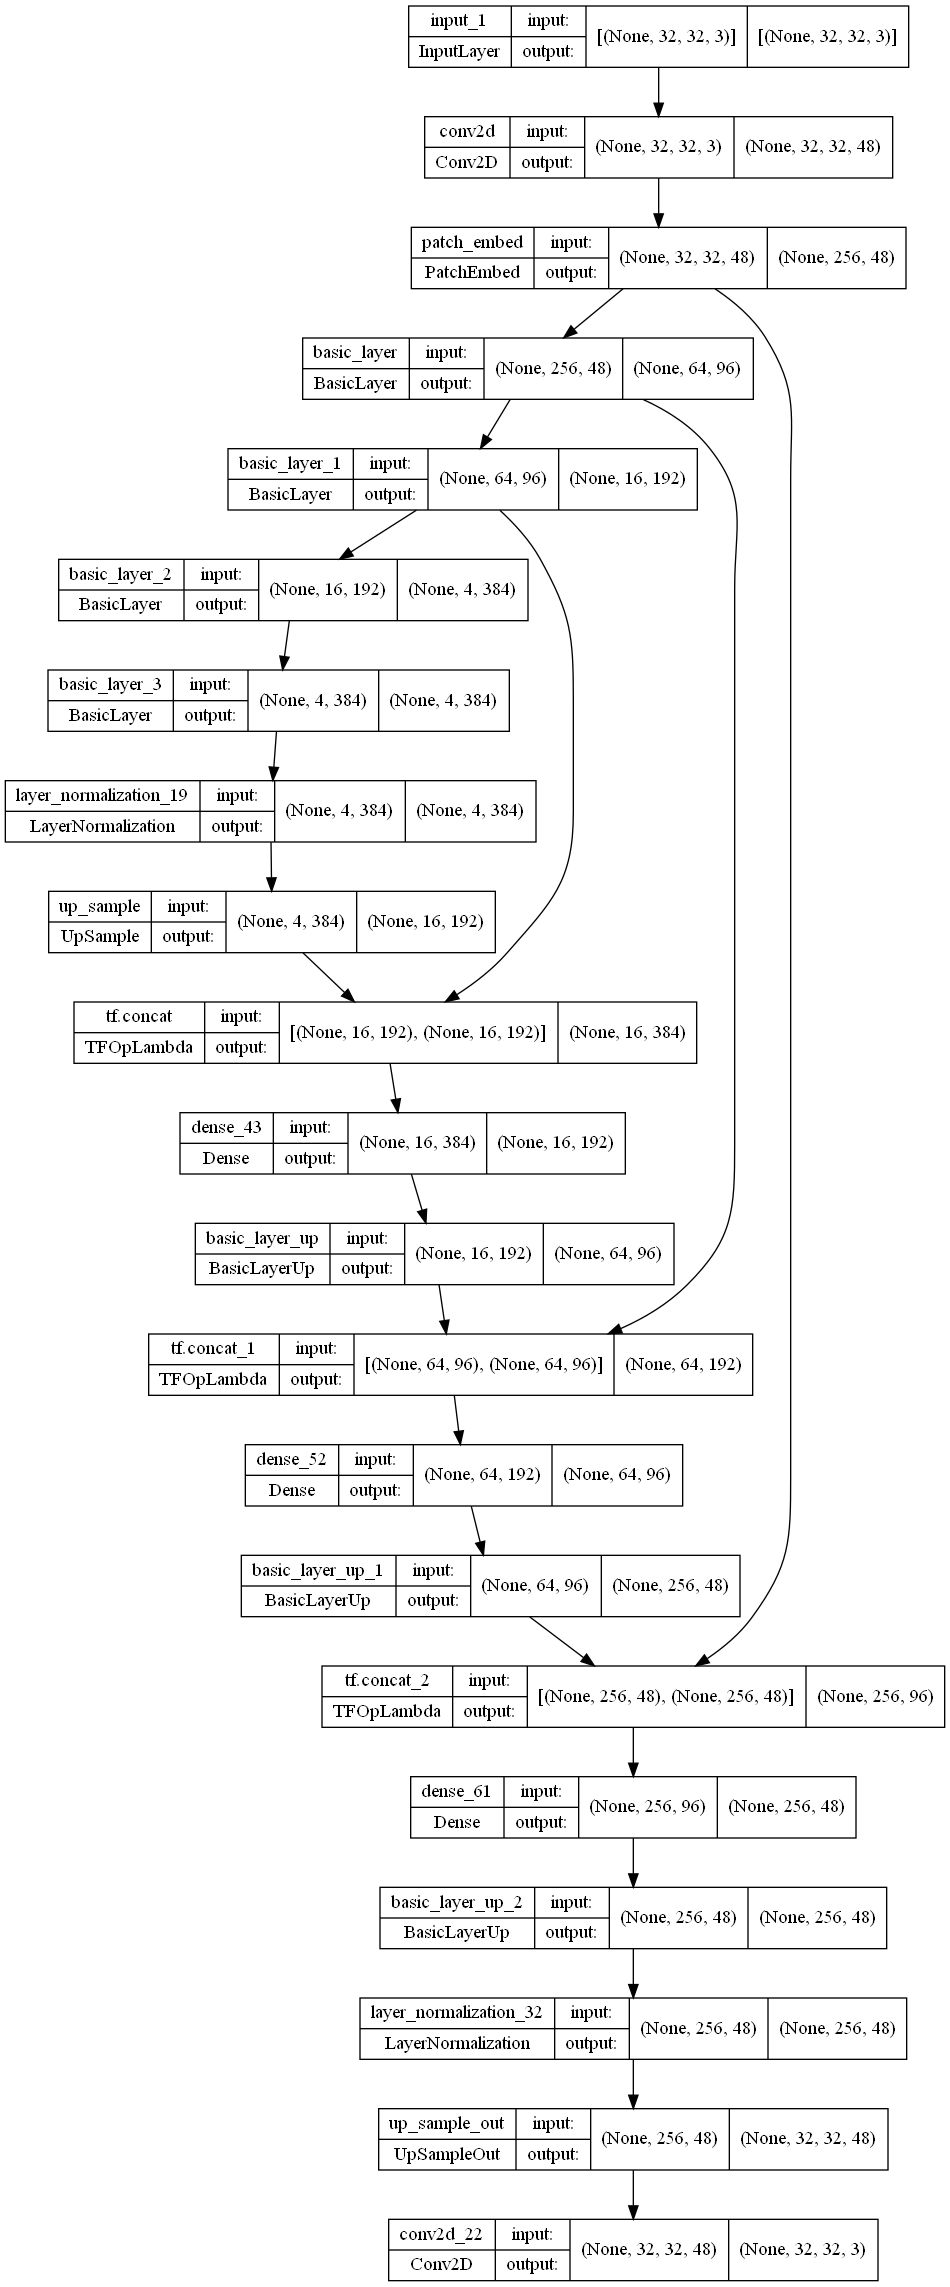

In [ ]:
ks.utils.plot_model(model=model, to_file='unet.png', show_shapes=True)

In [ ]:
# It is better to recreate the dataset because it depends on the batch_size and also because both the model cannot be trained without restarting the kernel.

batch_size = 64
train_ds = tf_data_generator(x_train, y_train, batch_size, augmentations=[horizontal_flip, vertical_flip, rotate])
val_ds = tf_data_generator(x_val, y_val, batch_size)

In [ ]:
from ks.callbacks import EarlyStopping, ModelCheckpoint
import os

working_dir = 'sunet'
loss = 'mae'
lr = 1e-3
epochs = 200
monitor = f'val_{metric}'
steps_per_epoch = 1.2 * len(x_train) // batch_size

early_stopping_callback = ks.callbacks.EarlyStopping(monitor=monitor, patience=40, verbose=1, mode='auto', restore_best_weights=True)
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=1e-5, factor=0.5, patience=5, verbose=1, mode='min')

checkpoint_dir = os.path.join(working_dir, 'ckpt')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_filepath = os.path.join(checkpoint_dir, 'weights_{epoch:02d}-{val_loss:.2f}.hdf5')
model_checkpoint_callback = tf.ks.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor=monitor,
    mode='min',
    save_weights_only=True,
    save_best_only=True)

backup_dir = os.path.join(working_dir, 'backup')
backup_callback = ks.callbacks.BackupAndRestore(backup_dir=backup_dir)

log_dir = os.path.join(working_dir, 'tensorboard-logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.ks.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    reduce_on_plateau_callback,
    early_stopping_callback,
    backup_callback,
    model_checkpoint_callback,
]

# Classical Transformers hyperparameters 
optimizer = ks.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# ks.backend.clear_session()
history = model.fit(train_ds, validation_data=val_ds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/190
843/843 [==============================] - 82s 80ms/step - loss: 0.0744 - mse: 0.0142 - val_loss: 0.0482 - val_mse: 0.0046 - lr: 0.0010
Epoch 2/190
843/843 [==============================] - 65s 77ms/step - loss: 0.0444 - mse: 0.0040 - val_loss: 0.0401 - val_mse: 0.0033 - lr: 0.0010
Epoch 3/190
843/843 [==============================] - 65s 77ms/step - loss: 0.0391 - mse: 0.0031 - val_loss: 0.0374 - val_mse: 0.0029 - lr: 0.0010
Epoch 4/190
843/843 [==============================] - 65s 77ms/step - loss: 0.0372 - mse: 0.0028 - val_loss: 0.0365 - val_mse: 0.0027 - lr: 0.0010
Epoch 5/190
843/843 [==============================] - 66s 78ms/step - loss: 0.0360 - mse: 0.0027 - val_loss: 0.0363 - val_mse: 0.0026 - lr: 0.0010
Epoch 6/190
843/843 [==============================] - 65s 77ms/step - loss: 0.0354 - mse: 0.0026 - val_loss: 0.0348 - val_mse: 0.0025 - lr: 0.0010
Epoch 7/190
843/843 [==============================] - 65s 77ms/step - loss: 0.0349 - mse: 0.0025 - val_loss: 0.

Epoch 56/190
843/843 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0020
Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
843/843 [==============================] - 66s 78ms/step - loss: 0.0309 - mse: 0.0020 - val_loss: 0.0320 - val_mse: 0.0022 - lr: 0.0010
Epoch 57/190
843/843 [==============================] - 65s 77ms/step - loss: 0.0305 - mse: 0.0020 - val_loss: 0.0314 - val_mse: 0.0021 - lr: 5.0000e-04
Epoch 58/190
843/843 [==============================] - 65s 77ms/step - loss: 0.0304 - mse: 0.0020 - val_loss: 0.0314 - val_mse: 0.0021 - lr: 5.0000e-04
Epoch 59/190
843/843 [==============================] - 65s 77ms/step - loss: 0.0303 - mse: 0.0020 - val_loss: 0.0314 - val_mse: 0.0021 - lr: 5.0000e-04
Epoch 60/190
843/843 [==============================] - 65s 77ms/step - loss: 0.0304 - mse: 0.0020 - val_loss: 0.0314 - val_mse: 0.0021 - lr: 5.0000e-04
Epoch 61/190
843/843 [==============================] - 65s 77ms/step - loss: 0.03

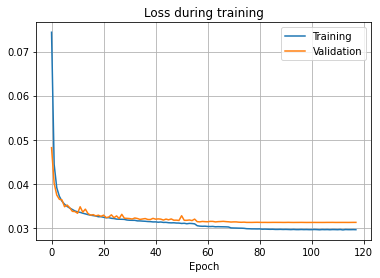

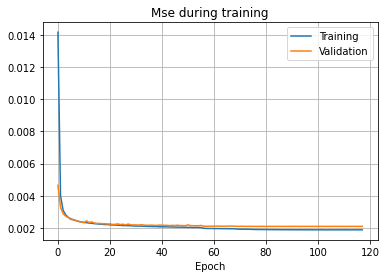

In [ ]:
display_history(history)